## RNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
np.set_printoptions(precision=6, suppress=True)
pd.options.display.float_format = '{:.5f}'.format
pd.reset_option('display.float_format')

In [3]:
from IPython.display import Image

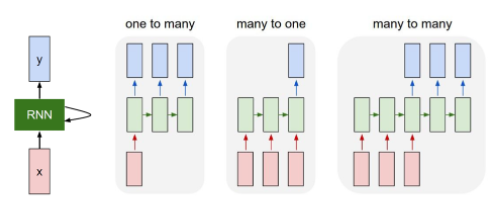

In [4]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/how_rnn.png')

  - 기존의 신경망과 동일하게 input layer, hidden layer, output이 있다.
  - 차이점은 이전의 input이 학습한 값이 그 다음에 들어오는 input의 학습과정에 전달된다.
  - input끼리 서로 시간적인 정보를 갖고 이루어져있다는 가정에서 사용하는 model이기에 앞에서 학습된 가중치의 값이 그 뒤의 input에도 계속 전달되는 구조이다.

* sin 함수 : sin 함수를 만들어서 RNN Model이 step을 예측하는 task를 진행해본다.

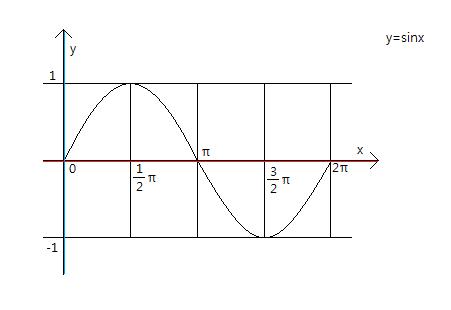

In [5]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/sin.png')

→ 아주 간단하게 sin 함수의 값을 잘 예측하는지 Model을 만들어볼 것이다.

In [6]:
s = np.sin(2 * np.pi)

In [7]:
s

-2.4492935982947064e-16

In [8]:
np.arange(20)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [9]:
s = np.sin(2 * np.pi * 0.125 * np.arange(20))

sin(0), sin(pi/4), sin(pi/2), sin(pi*3/4), ... 

In [10]:
s

array([ 0.      ,  0.707107,  1.      ,  0.707107,  0.      , -0.707107,
       -1.      , -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,
        0.      , -0.707107, -1.      , -0.707107, -0.      ,  0.707107,
        1.      ,  0.707107])

* 아래와 같은 함수를 예측해보자.
<br> - 3개의 point를 하나의 step
<br> - 전체 18개의 step

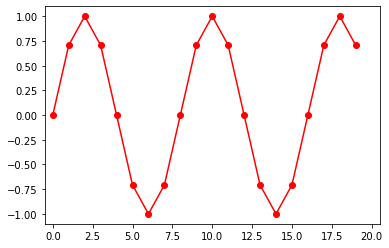

In [11]:
s = np.sin(2 * np.pi * 0.125 * np.arange(20))
plt.plot(s, 'ro-')
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.show()

* step 분할 : 이러한 작업을 통해서 sin 함수를 이루는 input, output 데이터 셋을 구축

In [12]:
s.shape[0]

20

In [13]:
from scipy.linalg import toeplitz
# 대각선 위의 성분이 같은 행렬(퇴플리츠행렬) : 즉, 하나의 행 그 다음은 그 행을 한 칸 미룬 행,, 순차적으로 자른 형태.
# ex) 
  # [1 3 2
  #  2 1 3 
  #  3 2 1 ]'''

→ input과 ouput을 시퀀스로 이어지도록 입/출력이 설정되어야하기 때문.

In [14]:
toeplitz([1,2,3], [1,4,5,6])

array([[1, 4, 5, 6],
       [2, 1, 4, 5],
       [3, 2, 1, 4]])

In [15]:
toeplitz([1, 2, 3, 4, 5], [1,2,4,5,6])

array([[1, 2, 4, 5, 6],
       [2, 1, 2, 4, 5],
       [3, 2, 1, 2, 4],
       [4, 3, 2, 1, 2],
       [5, 4, 3, 2, 1]])

In [16]:
toeplitz([1, 2], [1,4,5,6])

array([[1, 4, 5, 6],
       [2, 1, 4, 5]])

In [17]:
s

array([ 0.      ,  0.707107,  1.      ,  0.707107,  0.      , -0.707107,
       -1.      , -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,
        0.      , -0.707107, -1.      , -0.707107, -0.      ,  0.707107,
        1.      ,  0.707107])

In [18]:
s[-1]

0.7071067811865486

In [19]:
len(s)

20

In [20]:
s.shape[0] - 2

18

* s의 마지막 값에 0을 18개 concat

In [21]:
np.r_[s[-1], np.zeros(s.shape[0] - 2)]
# np.r_ : 두 배열 이어 붙이기

array([0.707107, 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
       0.      ])

* s를 reverse

In [22]:
s

array([ 0.      ,  0.707107,  1.      ,  0.707107,  0.      , -0.707107,
       -1.      , -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,
        0.      , -0.707107, -1.      , -0.707107, -0.      ,  0.707107,
        1.      ,  0.707107])

In [23]:
s[::-1]
# reverse

array([ 0.707107,  1.      ,  0.707107, -0.      , -0.707107, -1.      ,
       -0.707107,  0.      ,  0.707107,  1.      ,  0.707107, -0.      ,
       -0.707107, -1.      , -0.707107,  0.      ,  0.707107,  1.      ,
        0.707107,  0.      ])

* 위 두개의 list를 갖고 toeplitz 행렬 구성

In [24]:
np.r_[s[-1], np.zeros(s.shape[0] - 2)], s[::-1]

(array([0.707107, 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      ]),
 array([ 0.707107,  1.      ,  0.707107, -0.      , -0.707107, -1.      ,
        -0.707107,  0.      ,  0.707107,  1.      ,  0.707107, -0.      ,
        -0.707107, -1.      , -0.707107,  0.      ,  0.707107,  1.      ,
         0.707107,  0.      ]))

In [25]:
S = toeplitz(np.r_[s[-1], np.zeros(s.shape[0] - 2)], s[::-1])

In [26]:
S

array([[ 0.707107,  1.      ,  0.707107, -0.      , -0.707107, -1.      ,
        -0.707107,  0.      ,  0.707107,  1.      ,  0.707107, -0.      ,
        -0.707107, -1.      , -0.707107,  0.      ,  0.707107,  1.      ,
         0.707107,  0.      ],
       [ 0.      ,  0.707107,  1.      ,  0.707107, -0.      , -0.707107,
        -1.      , -0.707107,  0.      ,  0.707107,  1.      ,  0.707107,
        -0.      , -0.707107, -1.      , -0.707107,  0.      ,  0.707107,
         1.      ,  0.707107],
       [ 0.      ,  0.      ,  0.707107,  1.      ,  0.707107, -0.      ,
        -0.707107, -1.      , -0.707107,  0.      ,  0.707107,  1.      ,
         0.707107, -0.      , -0.707107, -1.      , -0.707107,  0.      ,
         0.707107,  1.      ],
       [ 0.      ,  0.      ,  0.      ,  0.707107,  1.      ,  0.707107,
        -0.      , -0.707107, -1.      , -0.707107,  0.      ,  0.707107,
         1.      ,  0.707107, -0.      , -0.707107, -1.      , -0.707107,
         0.      , 

In [27]:
S = np.fliplr(S)
# np.filplr : 좌우 반전

→ 3개의 point를 하나의 input으로 만들 수 있게 행렬변환

In [28]:
S

array([[ 0.      ,  0.707107,  1.      ,  0.707107,  0.      , -0.707107,
        -1.      , -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,
         0.      , -0.707107, -1.      , -0.707107, -0.      ,  0.707107,
         1.      ,  0.707107],
       [ 0.707107,  1.      ,  0.707107,  0.      , -0.707107, -1.      ,
        -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,  0.      ,
        -0.707107, -1.      , -0.707107, -0.      ,  0.707107,  1.      ,
         0.707107,  0.      ],
       [ 1.      ,  0.707107,  0.      , -0.707107, -1.      , -0.707107,
        -0.      ,  0.707107,  1.      ,  0.707107,  0.      , -0.707107,
        -1.      , -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,
         0.      ,  0.      ],
       [ 0.707107,  0.      , -0.707107, -1.      , -0.707107, -0.      ,
         0.707107,  1.      ,  0.707107,  0.      , -0.707107, -1.      ,
        -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,  0.      ,
         0.      , 

In [29]:
S.shape

(19, 20)

In [30]:
S[:-1, :].shape

(18, 20)

In [31]:
S[:, :3].shape

(19, 3)

In [32]:
S[:-1, :3]
# 마지막 행을 제외하고 3번째까지의 값

array([[ 0.      ,  0.707107,  1.      ],
       [ 0.707107,  1.      ,  0.707107],
       [ 1.      ,  0.707107,  0.      ],
       [ 0.707107,  0.      , -0.707107],
       [ 0.      , -0.707107, -1.      ],
       [-0.707107, -1.      , -0.707107],
       [-1.      , -0.707107, -0.      ],
       [-0.707107, -0.      ,  0.707107],
       [-0.      ,  0.707107,  1.      ],
       [ 0.707107,  1.      ,  0.707107],
       [ 1.      ,  0.707107,  0.      ],
       [ 0.707107,  0.      , -0.707107],
       [ 0.      , -0.707107, -1.      ],
       [-0.707107, -1.      , -0.707107],
       [-1.      , -0.707107, -0.      ],
       [-0.707107, -0.      ,  0.707107],
       [-0.      ,  0.707107,  1.      ],
       [ 0.707107,  1.      ,  0.707107]])

In [33]:
 S[:-1, 3]
 # 마지막 행을 제외하고 4번째 값

array([ 0.707107,  0.      , -0.707107, -1.      , -0.707107, -0.      ,
        0.707107,  1.      ,  0.707107,  0.      , -0.707107, -1.      ,
       -0.707107, -0.      ,  0.707107,  1.      ,  0.707107,  0.      ])

In [34]:
X_train = S[:-1, :3][:, :, np.newaxis]
# 마지막 행을 제외하고 3번째 값까지로 input : 3-point
Y_train = S[:-1, 3]
# 마지막 행을 제외하고 3번째 값으로 output : 1-point

In [35]:
X_train[0] # 첫번째 입력

array([[0.      ],
       [0.707107],
       [1.      ]])

In [36]:
Y_train[0] # 첫번째 입력 이후 나와야하는 값

0.7071067811865476

* sin 함수

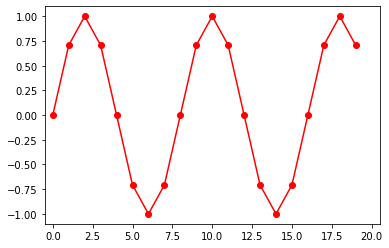

In [37]:
s = np.sin(2 * np.pi * 0.125 * np.arange(20))
plt.plot(s, 'ro-')
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.show()

* step 별 예측해야하는 지점

Text(0.5, 1.0, 'First sample sequence')

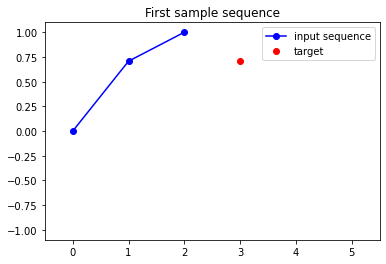

In [38]:
plt.plot([0, 1, 2], X_train[0].flatten(), 'bo-', label="input sequence")
plt.plot([3], Y_train[0], 'ro', label="target")
plt.xlim(-0.5, 5.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("First sample sequence")

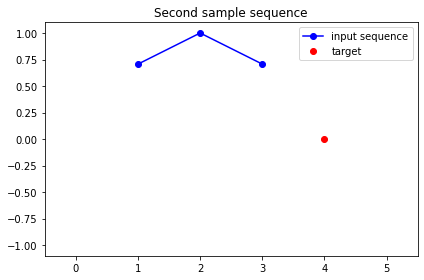

In [ ]:
plt.plot([1, 2, 3], X_train[1].flatten(), 'bo-', label="input sequence")
plt.plot([4], Y_train[1], 'ro', label="target")
plt.xlim(-0.5, 5.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.tight_layout()
plt.show()

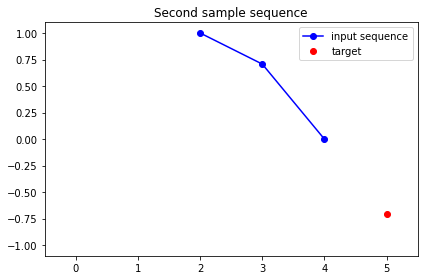

In [ ]:
plt.plot([2, 3, 4], X_train[2].flatten(), 'bo-', label="input sequence")
plt.plot([5], Y_train[2], 'ro', label="target")
plt.xlim(-0.5, 5.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.tight_layout()
plt.show()

* RNN Model

* 구조

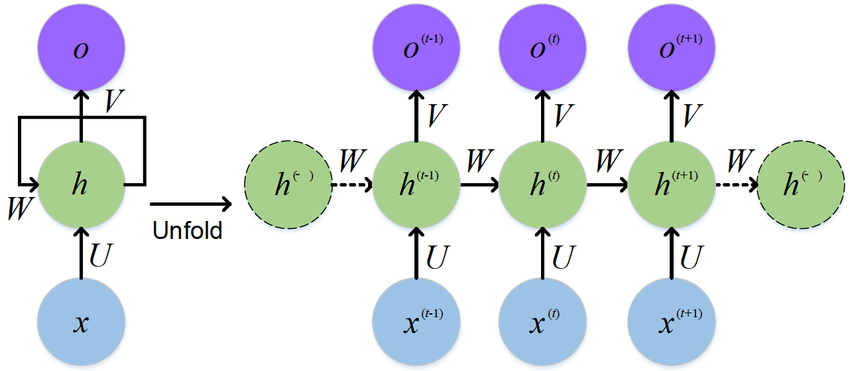

In [39]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/rnn.png')

  - input data가 입력되면, hidden layer는 바로 output으로 연산을 하면서 그때의 가중치를 다시 그 다음 input에게 전달한다.
  - 왼쪽과 오른쪽은 같은 의미이다.

* 연산

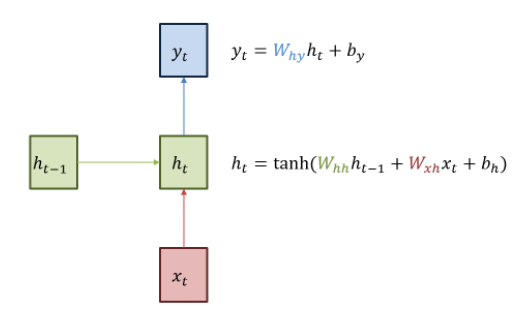

In [40]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/how_rnn2.png')

  - ht : 기존의 신경망에서는 tanh(W_xh * x_t + b_n)만 존재하였는데 이전층의 정보 W_hh * h_t-1이 더해진것을 알 수 있다.

In [41]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

* Many to one Model

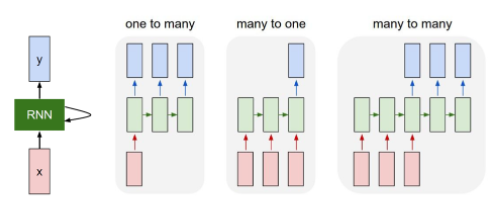

In [42]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/how_rnn.png')

   - 각 step에서의 hidden layer 마다 output을 내보낼 수 도 있고 내보내지 않을 수도 있다. 

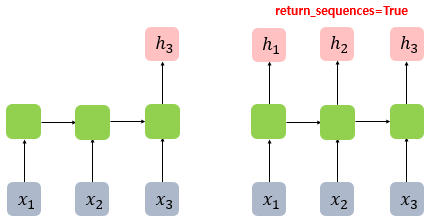

In [43]:
Image('/content/drive/MyDrive/CDS2(2022-2)/RNN_VIT/rseq.png')

→ return_sequences=False로 두면 하나의 값만 출력한다. 현재 우리는 하나의 point를 예측할 것이기에 False로 둔다.

In [44]:
model = Sequential()
model.add(SimpleRNN(10, input_dim=1, input_length=3, return_sequences=False)) # input_shape=(3,1)과 동일
# 단일 시계열 이기에 input_dim : 1, 입력 step length : 3
model.add(Dense(1))
# 아주 간단한 RNN 

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


* Total params = recurrent_weights + input_weights + biases
<br> = (num_units x num_units)+(num_features x num_units) + (1 x num_units)

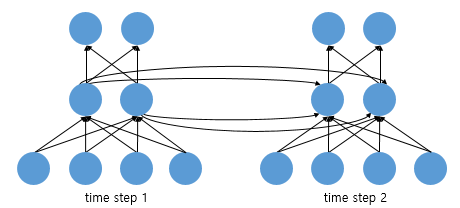

In [46]:
Image('/content/drive/MyDrive/CDS2(2022-2)/RNN_VIT/numl.png')

→ 입력 벡터가 4차원, 은닉 상태가 2, 출력이 2인 모델

In [47]:
10 * 10 + 1 * 10 + 10

120

→ 10개의 은닉층

In [48]:
10 + 1

11

→ 1개의 Dense Layer

In [49]:
model.compile(loss='mse', optimizer='sgd')

* 학습하지 않은 모델로 예측

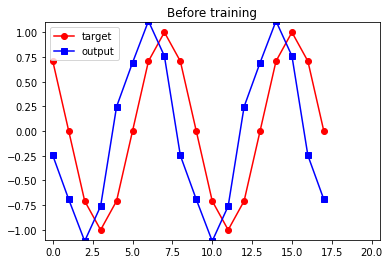

In [51]:
plt.plot(Y_train, 'ro-', label="target")
plt.plot(model.predict(X_train[:,:,:]), 'bs-', label="output")
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Before training")
plt.show()

In [52]:
X_train.shape
# 길이 3 point 입력 -> 그 다음 1 point 예측

(18, 3, 1)

In [53]:
Y_train.shape
# 1 point

(18,)

In [54]:
history = model.fit(X_train, Y_train, epochs=100, verbose=1)

Epoch 1/100
1/1 [==============================] - 1s 841ms/step - loss: 0.4351
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 0.3779
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 0.3290
Epoch 4/100
1/1 [==============================] - 0s 12ms/step - loss: 0.2872
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2513
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.2206
Epoch 7/100
1/1 [==============================] - 0s 10ms/step - loss: 0.1943
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1718
Epoch 9/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1524
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1358
Epoch 11/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1215
Epoch 12/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1093
Epoch 13/100
1/1 [==============================] - 0

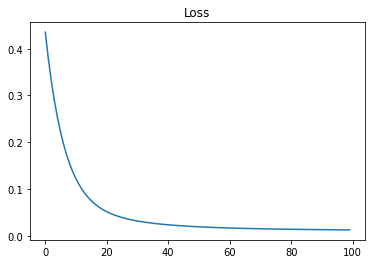

In [55]:
plt.plot(history.history["loss"])
plt.title("Loss")
plt.show()

* 학습이 잘 되었는지 확인

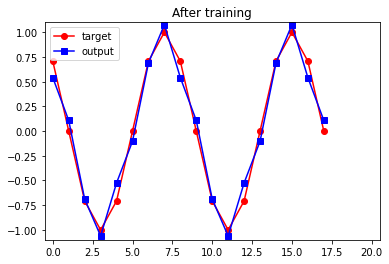

In [56]:
plt.plot(Y_train, 'ro-', label="target")
plt.plot(model.predict(X_train), 'bs-', label="output")
plt.xlim(-0.5, 20.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("After training")
plt.show()

* 이번에는 출력도 3개의 point로 한다 즉, 3개의 point를 input으로 output도 동일한 길이

> 들여쓴 블록



In [57]:
X_train2 = S[:-3, 0:3][:, :, np.newaxis]
Y_train2 = S[:-3, 3:6][:, :, np.newaxis]
# 앞서 Y는 그 다음 스텝의 값 1개로 했으나 이번에는 3 point로 설정
X_train2.shape, Y_train2.shape

((16, 3, 1), (16, 3, 1))

In [58]:
X_train2.shape

(16, 3, 1)

In [59]:
Y_train2.shape

(16, 3, 1)

In [60]:
X_train2[0]

array([[0.      ],
       [0.707107],
       [1.      ]])

In [61]:
X_train2[0].flatten()

array([0.      , 0.707107, 1.      ])

Text(0.5, 1.0, 'First sample sequence')

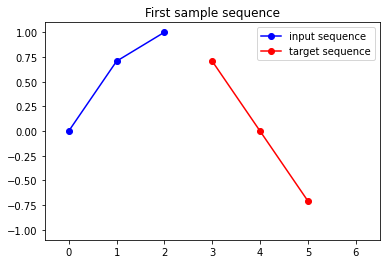

In [62]:
plt.plot([0, 1, 2], X_train2[0].flatten(), 'bo-', label="input sequence")
plt.plot([3, 4, 5], Y_train2[0].flatten(), 'ro-', label="target sequence")
plt.xlim(-0.5, 6.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("First sample sequence")

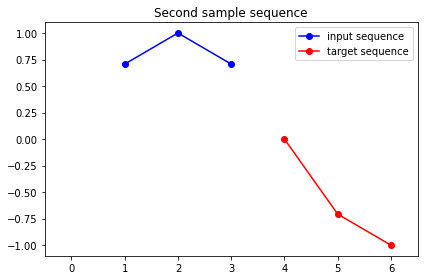

In [63]:
plt.plot([1, 2, 3], X_train2[1].flatten(), 'bo-', label="input sequence")
plt.plot([4, 5, 6], Y_train2[1].flatten(), 'ro-', label="target sequence")
plt.xlim(-0.5, 6.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")
plt.tight_layout()
plt.show()

* Many to many Model

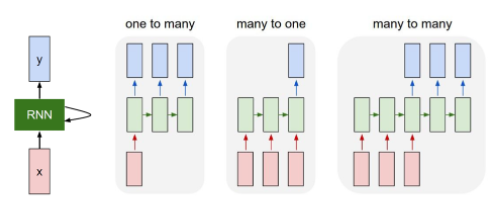

In [64]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/how_rnn.png')

→ 각각의 input point에 해당하는 은닉상태 값을 모두 출력<br>many to many model에서는 각 point 마다의 output이 필요하다.

* Many to many Model

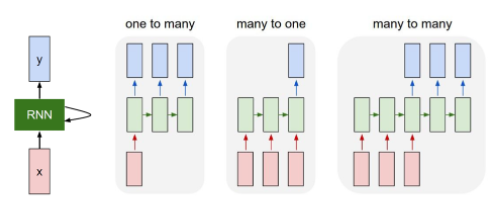

In [65]:
Image('/content/drive/MyDrive/CDS2(2022-2)/img/05/how_rnn.png')

In [66]:
from keras.layers import TimeDistributed

model2 = Sequential()
model2.add(SimpleRNN(20, input_dim=1, input_length=3, return_sequences=True))
# return_sequences를 true로 하면 마지막 값 뿐 아니라 모든 시점에서의 은닉 상태 출력 : many to many 가능
model2.add(TimeDistributed(Dense(1)))
# TimeDistributed : many to many 
model2.compile(loss='mse', optimizer='sgd')

In [67]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3, 20)             440       
                                                                 
 time_distributed (TimeDistr  (None, 3, 1)             21        
 ibuted)                                                         
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


In [68]:
20 * 20 + 1 * 20 + 20

440

In [69]:
20 + 1

21

* 학습

In [70]:
history2 = model2.fit(X_train2, Y_train2, epochs=200, verbose=1)

Epoch 1/200
1/1 [==============================] - 1s 776ms/step - loss: 0.1401
Epoch 2/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1379
Epoch 3/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1359
Epoch 4/200
1/1 [==============================] - 0s 6ms/step - loss: 0.1340
Epoch 5/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1323
Epoch 6/200
1/1 [==============================] - 0s 8ms/step - loss: 0.1307
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1293
Epoch 8/200
1/1 [==============================] - 0s 8ms/step - loss: 0.1280
Epoch 9/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1268
Epoch 10/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1257
Epoch 11/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1247
Epoch 12/200
1/1 [==============================] - 0s 7ms/step - loss: 0.1238
Epoch 13/200
1/1 [==============================] - 0s 9ms/

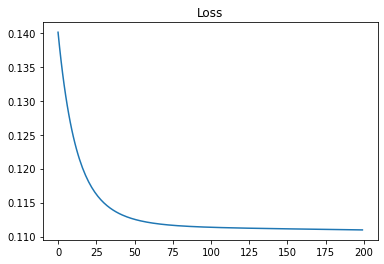

In [71]:
plt.plot(history2.history["loss"])
plt.title("Loss")
plt.show()

Text(0.5, 1.0, 'Second sample sequence')

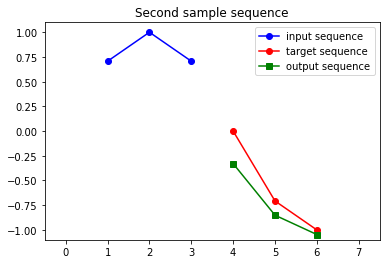

In [72]:
plt.plot([1, 2, 3], X_train2[1].flatten(), 'bo-', label="input sequence")
plt.plot([4, 5, 6], Y_train2[1].flatten(), 'ro-', label="target sequence")
plt.plot([4, 5, 6], model2.predict(X_train2[1:2,:,:]).flatten(), 'gs-', label="output sequence")
plt.xlim(-0.5, 7.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Second sample sequence")

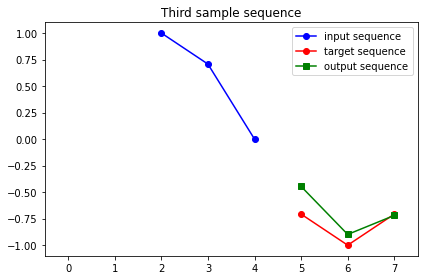

In [73]:
plt.plot([2, 3, 4], X_train2[2].flatten(), 'bo-', label="input sequence")
plt.plot([5, 6, 7], Y_train2[2].flatten(), 'ro-', label="target sequence")
plt.plot([5, 6, 7], model2.predict(X_train2[2:3,:,:]).flatten(), 'gs-', label="output sequence")
plt.xlim(-0.5, 7.5)
plt.ylim(-1.1, 1.1)
plt.legend()
plt.title("Third sample sequence")
plt.tight_layout()
plt.show()